In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [70]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

from sklearn.metrics import v_measure_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

In [30]:
from sklearn.datasets import load_digits

In [31]:
digits = load_digits()

In [32]:
images = digits.images
y = digits.target
data = digits.data

In [33]:
MAX_COLOR_INDEX = 16
IMAGE_SIZE = images[0].shape
DATA_SIZE = data[0].shape

### Инвертируем цвет пикселей с черного на белый

In [34]:
def inverse_color(data):
    '''inverse image color'''
    return np.full(DATA_SIZE, MAX_COLOR_INDEX) - data

In [35]:
def inverse_images(images, stop_index=10):
    '''inverse images color'''
    return [inverse_color(images[i]) for i in range(stop_index)]

In [36]:
def visualize_digits(data, n_rows, n_cols, n_digits_show, inversion=True):
    '''visualize digits'''
    if inversion:
        data = inverse_images(data, stop_index=data.shape[0])
    plt.gray()
    for i in range(1, n_digits_show + 1):
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(data[i - 1].reshape(8, 8))
    plt.show()

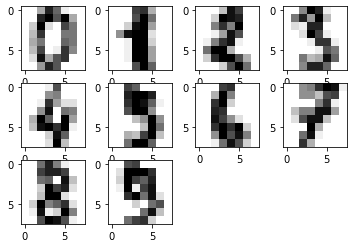

In [37]:
visualize_digits(np.copy(data[0:10]), n_rows=3, n_cols=4, n_digits_show=10, inversion=True)

### Кластеризуем изображения с помощью k-means

In [38]:
N_DIGITS_CLUSTERS = 10

In [39]:
K_MEANS_MAX_ITERATIONS = 250
N_JOBS_STATUS = -1
K_MEANS_N_INITS = 100

In [40]:
k_means_clustering = KMeans(n_clusters=N_DIGITS_CLUSTERS,
                            n_init=K_MEANS_N_INITS,
                            max_iter=K_MEANS_MAX_ITERATIONS,
                            n_jobs=N_JOBS_STATUS)
k_means_clustering.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=250,
       n_clusters=10, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
prediction_k_means = k_means_clustering.predict(data)

### Используем метрики в качестве оценки v_measure_score, completness_score, homogeneity_score

In [42]:
v_measure_score(y, prediction_k_means)

0.7429016982617717

In [43]:
completeness_score(y, prediction_k_means)

0.7472957587655563

In [44]:
homogeneity_score(y, prediction_k_means)

0.7385590093935099

In [45]:
def get_mean_points(data, labels):
    '''get cluster centers'''
    pd_data = pd.DataFrame(data=data, index=labels)
    return [pd_data[pd_data.index == i].values.mean(axis=0)
                for i in range(np.unique(labels).shape[0])]

In [46]:
mean_points_k_means = get_mean_points(data, prediction_k_means)

### Визуализируем центры кластеров, в принципе часть изображений похожи на типичные изображения кластеров

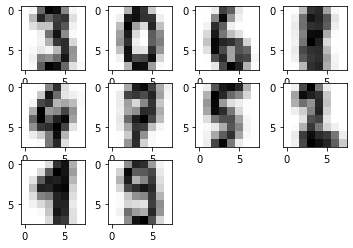

In [47]:
visualize_digits(np.copy(mean_points_k_means), 3, 4, 10)

### Кластеризуем данные с помощью иерархической кластеризации

In [48]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=N_DIGITS_CLUSTERS,
                                                  compute_full_tree=True,
                                                  linkage='ward').fit(data)

In [49]:
prediction_hierarchical = hierarchical_clustering.labels_

### Cамая максимальная v-мера по выбору метрики Ворда (в отличии от других метрик она также учитывает дисперсию)

### иерархическая кластеризация справляется лучше по метрикам, чем KMeans

In [50]:
v_measure_score(y, prediction_hierarchical)

0.8681701126909083

In [51]:
completeness_score(y, prediction_hierarchical)

0.8790955851724198

In [52]:
homogeneity_score(y, prediction_hierarchical)

0.8575128719504723

In [53]:
mean_points_hierarchical = get_mean_points(data, prediction_hierarchical)

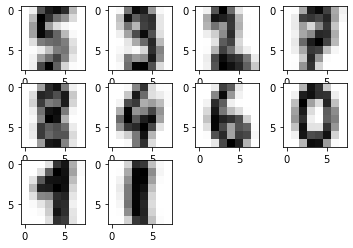

In [54]:
visualize_digits(np.copy(mean_points_hierarchical), 3, 4, 10)

In [59]:
CLUSTER_NUMBER_LOWER_BOUND = 2
CLUSTER_NUMBER_UPPER_BOUND = 21

In [60]:
clusters_k_means = [KMeans(n_clusters=i,
                            n_init=K_MEANS_N_INITS,
                            max_iter=K_MEANS_MAX_ITERATIONS,
                            n_jobs=N_JOBS_STATUS).fit_predict(data)
                    for i in range(CLUSTER_NUMBER_LOWER_BOUND, CLUSTER_NUMBER_UPPER_BOUND)]

In [61]:
clusters_hierarchical = [AgglomerativeClustering(n_clusters=i,
                                                 linkage='ward').fit(data).labels_ 
                         for i in range(CLUSTER_NUMBER_LOWER_BOUND, CLUSTER_NUMBER_UPPER_BOUND)]

In [62]:
# compute silhouette score with different cluster number
sil_k_means = [silhouette_score(data, el) for el in clusters_k_means]
sil_hier = [silhouette_score(data, el) for el in clusters_hierarchical] 
K = [K for K in range(CLUSTER_NUMBER_LOWER_BOUND, CLUSTER_NUMBER_UPPER_BOUND)]

### по графику можно сделать вывод, что силует у k-means почти везде превосходит силует hierarchical clustering, потому что задача оптимизации k-means - это минимизировать суммарное квадратичное отклонение точек кластеров от центров этих кластеров

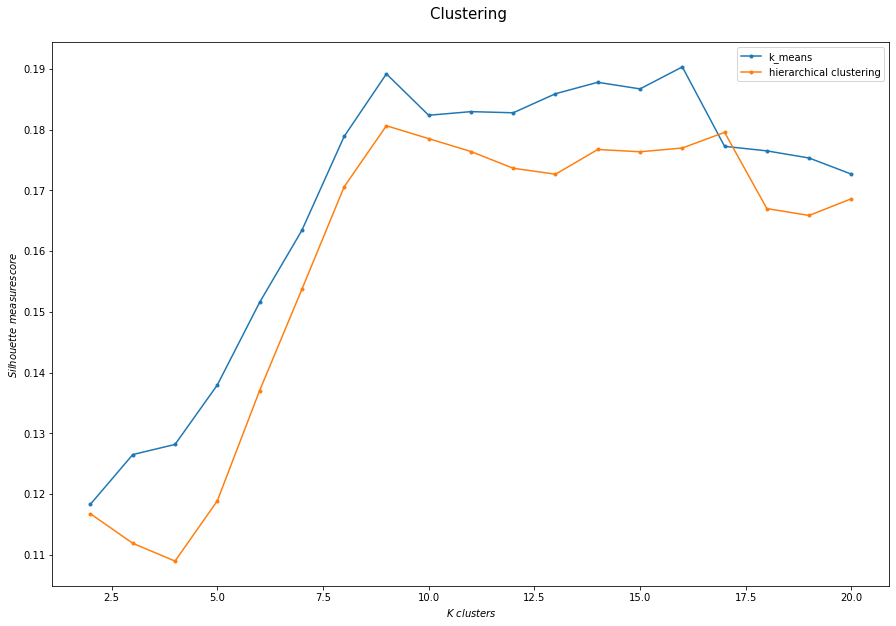

In [63]:
fig, ax = plt.subplots()
ax.plot(K, sil_k_means, label='k_means', marker='.')
ax.plot(K, sil_hier, label='hierarchical clustering', marker='.')
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.xlabel('$ K\\  clusters $')
plt.ylabel('$ Silhouette\\   measure score$');    
plt.title('Clustering \n', fontsize = 15)
plt.show()

In [71]:
def plot_external_measures(x_value,
                           v_ms,
                           hom_ms,
                           compl_ms,
                           title='K-means clustering external measures',
                           xtitle='X clusters',
                           ytitle='measure scores'):
    """
    
    Summary line
    
    plot external measures
    
    Parameters:
    x_value (list): x value of plot
    v_ms (list): v_measure_score list
    hom_ms (list): homogenity_score list
    compl_ms (list): completeness_score list
    title (str): the title of the plot
    xtitle (str): the title of the xlabel
    ytitle (str): the title of the ylabel
    
    """
    fig, ax = plt.subplots()
    ax.plot(x_value, v_ms, label='v-measure', marker='.')
    ax.plot(x_value, hom_ms, label='homogenity measure', marker='.')
    ax.plot(x_value, compl_ms, label='completeness measure', marker='.')
    ax.legend()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle);    
    plt.title(title, fontsize = 15)
    plt.show()

### Визулализация мер k-means, максимум v-меры достигается при разбиении данных на 16 кластеров

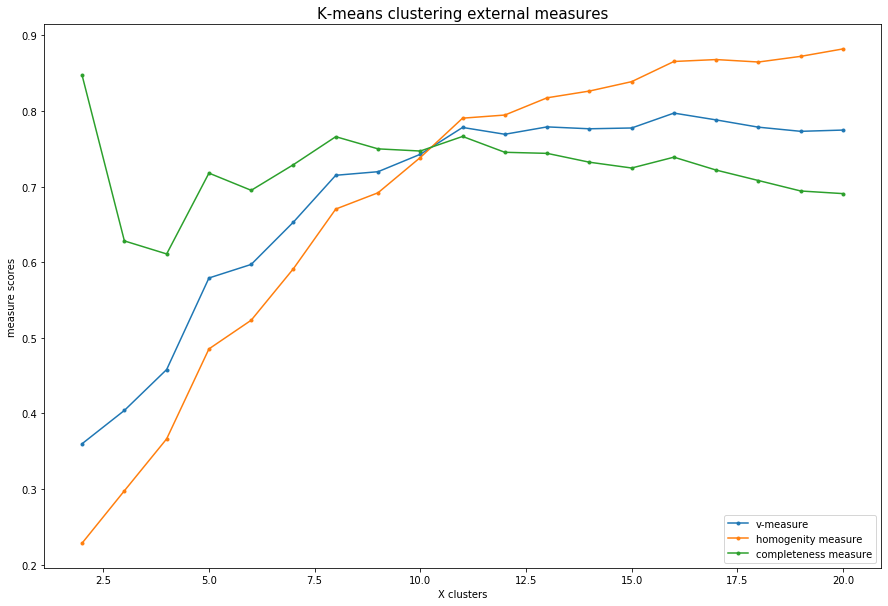

In [72]:
v_measures = [v_measure_score(y, el) for el in clusters_k_means]
homogenity_measures = [homogeneity_score(y, el) for el in clusters_k_means]
completeness_measures = [completeness_score(y, el) for el in clusters_k_means]

plot_external_measures(K, v_measures, homogenity_measures, completeness_measures)

### Визуализация мер иерархической кластеризации, максимум v-меры достигается при разбиении данных на 10 кластеров

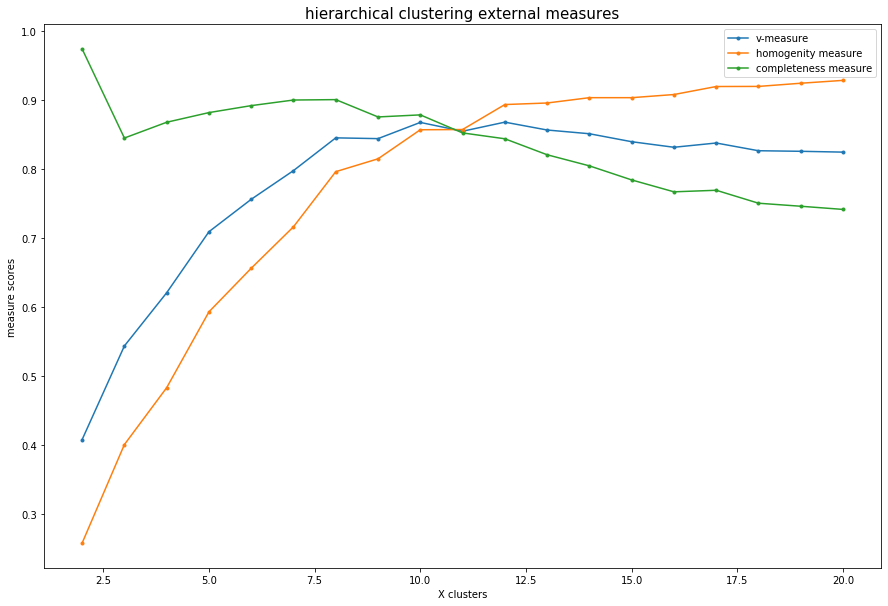

In [73]:
v_measures = [v_measure_score(y, el) for el in clusters_hierarchical]
homogenity_measures = [homogeneity_score(y, el) for el in clusters_hierarchical]
completeness_measures = [completeness_score(y, el) for el in clusters_hierarchical]

plot_external_measures(K,
                       v_measures,
                       homogenity_measures,
                       completeness_measures,
                       title='hierarchical clustering external measures')

### На данном этапе мы понизим размерность с помощью PCA и TruncatedSVD, затем исследуем внешние метрики

In [75]:
# define n_components for PCA and SVD methods
n_components = [2, 5, 10, 20, 40, 50, 63]

# lower dimension via PCA and SVD with different components
SVD_reduction_matrices = [TruncatedSVD(n_components=el, n_iter=20).fit_transform(data) for el in n_components]
PCA_reduction_matrices = [PCA(n_components=el).fit_transform(data) for el in n_components]

In [81]:
# cluster lower-dimension (PCA method with different components) data via k-means
SVD_clusters_k_means = [KMeans(n_clusters=10,
                                n_init=100,
                                max_iter=250,
                                n_jobs=-1).fit_predict(el) for el in SVD_reduction_matrices]

In [77]:
# cluster lower-dimension (PCA method with different components) data via AgglomerativeClustering
SVD_clusters_hierarchical = [AgglomerativeClustering(n_clusters=N_DIGITS_CLUSTERS,
                                                     linkage='ward').fit(el).labels_ for el in SVD_reduction_matrices]

In [78]:
# cluster lower-dimension (SVD method with different components) data via k-means 
PCA_clusters_k_means = [KMeans(n_clusters=10,
                                n_init=100,
                                max_iter=250,
                                n_jobs=-1).fit_predict(el) for el in PCA_reduction_matrices]

In [79]:
# cluster lower-dimension (SVD method with different components) data via AgglomerativeClustering 
PCA_clusters_hierarchical = [AgglomerativeClustering(n_clusters=N_DIGITS_CLUSTERS,
                                                     linkage='ward').fit(el).labels_
                                                        for el in PCA_reduction_matrices]

In [83]:
# compute external measures for SVD_clusters_k_means
v_measures = [v_measure_score(y, el) for el in SVD_clusters_k_means]
completeness_measures = [completeness_score(y, el) for el in SVD_clusters_k_means]
homogenity_measures = [homogeneity_score(y, el) for el in SVD_clusters_k_means]

### Вывод: начиная c 20 компонент, внешние метрики практически остаются постоянными

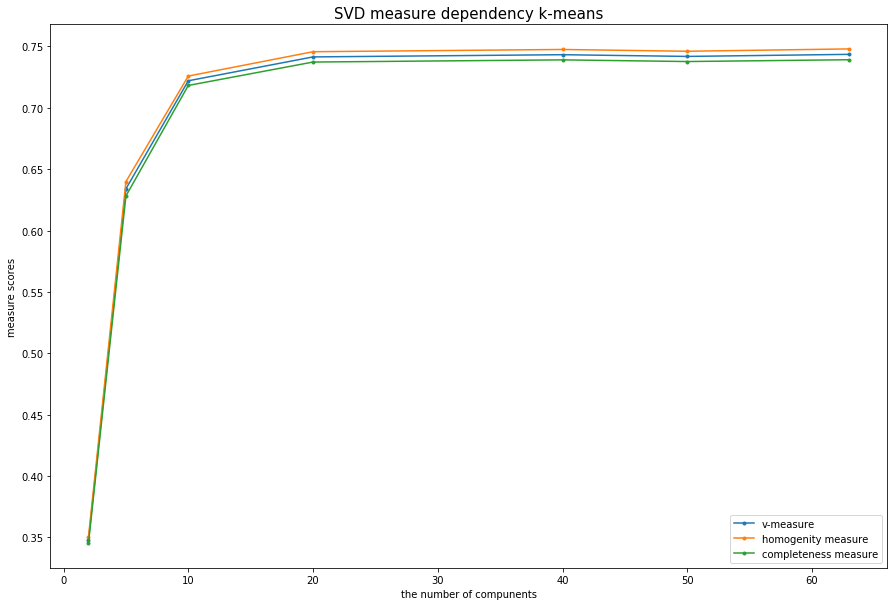

In [84]:
plot_external_measures(n_components,
                       v_measures,
                       completeness_measures,
                       homogenity_measures,
                       title='SVD measure dependency k-means',
                       xtitle='the number of compunents')

In [459]:
# compute external measures for SVD_clusters_hierarchical
v_measures = [v_measure_score(y, el) for el in SVD_clusters_hierarchical]
completeness_measures = [completeness_score(y, el) for el in SVD_clusters_hierarchical]
homogenity_measures = [homogeneity_score(y, el) for el in SVD_clusters_hierarchical]

### Вывод: начиная c 50 компонент, внешние метрики практически остаются постоянными

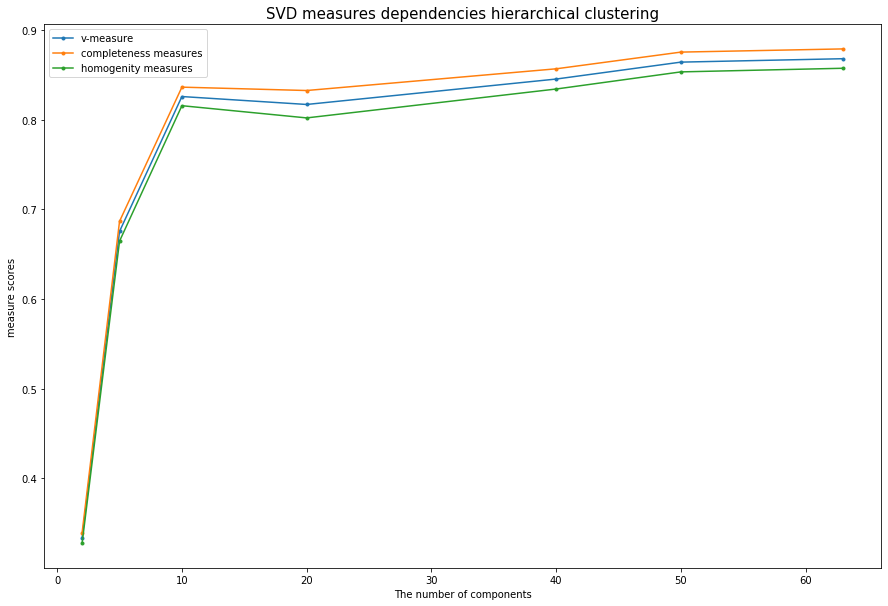

In [460]:
plot_measure_dependency(n_components,
                        v_measures,
                        completeness_measures,
                        homogenity_measures,
                        title='SVD measures dependencies hierarchical clustering')

In [461]:
# compute external measures for PCA_clusters_k_means
v_measures = [v_measure_score(y, el) for el in PCA_clusters_k_means]
completeness_measures = [completeness_score(y, el) for el in PCA_clusters_k_means]
homogenity_measures = [homogeneity_score(y, el) for el in PCA_clusters_k_means]

### Вывод: начиная c 20 компонент, внешние метрики практически остаются постоянными

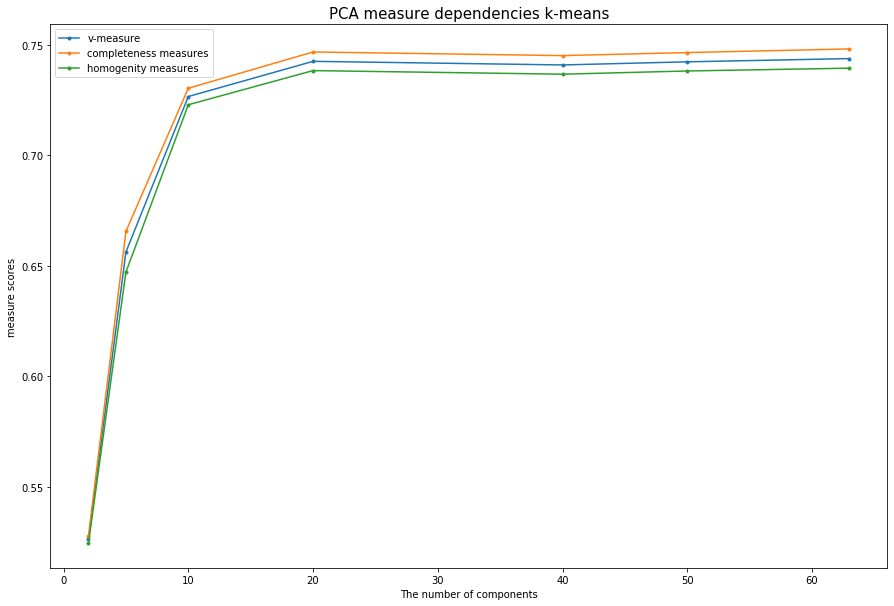

In [462]:
plot_measure_dependency(n_components,
                        v_measures,
                        completeness_measures,
                        homogenity_measures,
                        title='PCA measure dependencies k-means')

In [463]:
# compute external measures for PCA_clusters_hierarchical
v_measures = [v_measure_score(y, el) for el in PCA_clusters_hierarchical]
completeness_measures = [completeness_score(y, el) for el in PCA_clusters_hierarchical]
homogenity_measures = [homogeneity_score(y, el) for el in PCA_clusters_hierarchical]

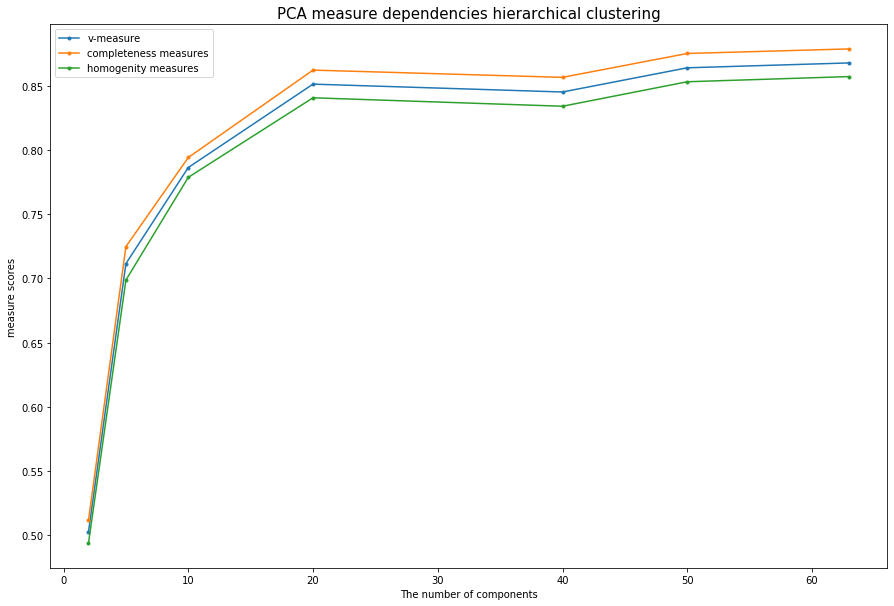

In [464]:
plot_measure_dependency(n_components,
                        v_measures,
                        completeness_measures,
                        homogenity_measures,
                        title='PCA measure dependencies hierarchical clustering')

### теперь рассмотрим, как спроецирует метод понижения размерности TNSE на двумерную плоскость

In [466]:
TNSE_reduction_matrix = TSNE(n_components=2, n_iter=500).fit_transform(data)

### данный метод очень хорошо спроецировал на двумерную плоскость в отличии от pca

Text(0.5, 1.0, 'TSNE points')

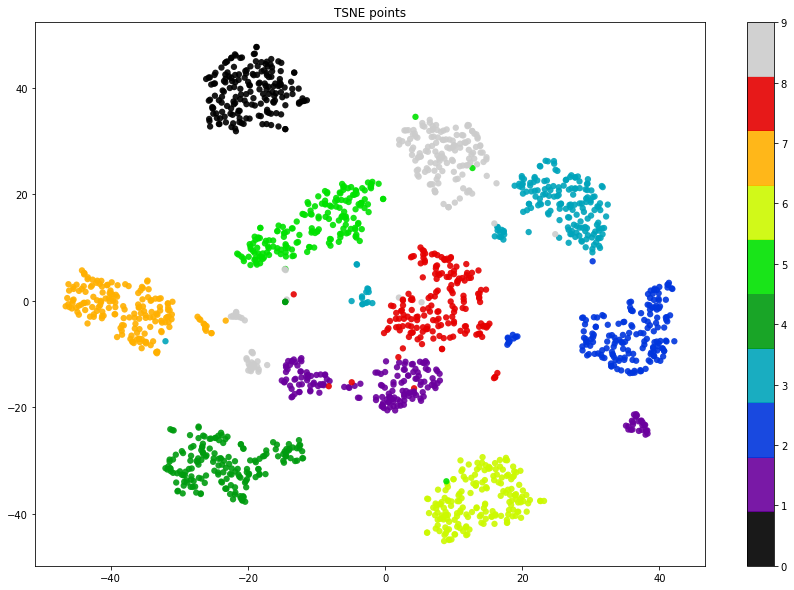

In [467]:
plt.figure(figsize=(15,10))
plt.scatter(TNSE_reduction_matrix[:, 0], TNSE_reduction_matrix[:, 1], c=y, 
            edgecolor='none', alpha=0.9, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('TSNE points')
# вывод: tnse метод очень хорошо проецирует изображения на двумерную плоскость, в отличии от pca метода

Text(0.5, 1.0, 'TSNE points')

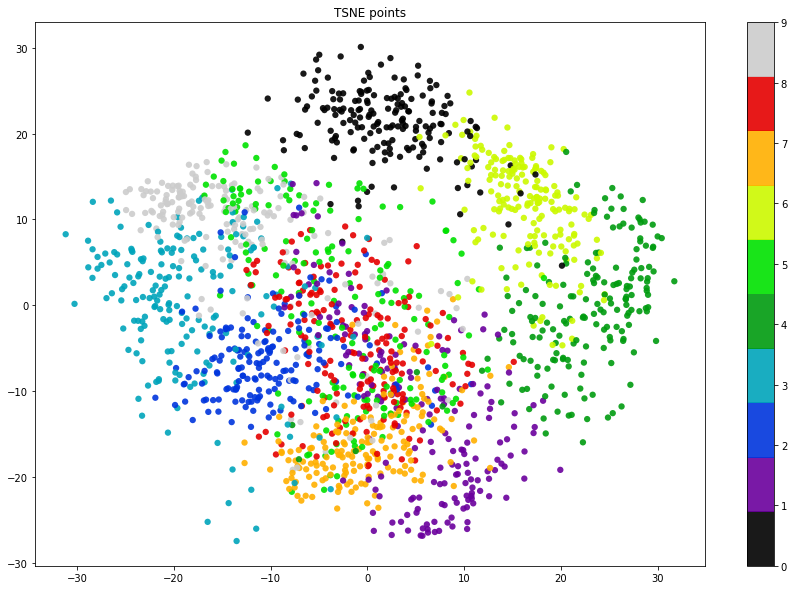

In [468]:
plt.figure(figsize=(15,10))
plt.scatter(PCA_reduction_matrices[0][:, 0], PCA_reduction_matrices[0][:, 1], c=y, 
            edgecolor='none', alpha=0.9, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('TSNE points')

### Вывод: при снижении 64-мерного пространства до 20-30 размерности практически не изменят результат v-меры и силуета